In [1]:
# import libraries

from tensortrade.env.generic import Renderer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Extension imports
# import sys
# sys.path.append("..")
# we are now at the parent root

In [3]:
from tensortrade.oms.instruments import Instrument
# Setup Instruments
USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 2, "TensorTrade Coin")

Action Space: Discrete(2)
State Space: (30, 5)
Next observation
{'internal': {'sine-wave:/USD-TTC': 100.0, 'sine-wave:/USD:/free': 100.0, 'sine-wave:/USD:/locked': 0.0, 'sine-wave:/USD:/total': 100.0, 'sine-wave:/TTC:/free': 0.0, 'sine-wave:/TTC:/locked': 0.0, 'sine-wave:/TTC:/total': 0.0, 'sine-wave:/TTC:/worth': 0.0, 'net_worth': 100.0}, 'external': {'sine-wave:/USD-TTC': 100.0, 'fast': 100.0, 'medium': 100.0, 'slow': 100.0, 'lr': 0}, 'renderer': {'price': 'price', 'action': 0}}


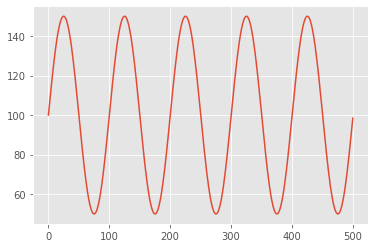

In [4]:
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import PBR
from tensortrade.env import default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

from tensortradeExtension.data.sine import SineWaveDataGenerator
from tensortradeExtension.env.generic.components.renderer.bhsPositionChangeChart import PositionChangeChart

data_generator = SineWaveDataGenerator(y_peaks=5)

# Create the environement
def create_env(dataframe):
		price_stream = Stream.source(list(dataframe['price']), dtype="float").rename("USD-TTC")
		sinewavee_xchange = Exchange("sine-wave", service=execute_order, options=ExchangeOptions(commission=0.00075))(
				price_stream
		)
		cash = Wallet(sinewavee_xchange, 100 * USD)
		asset = Wallet(sinewavee_xchange, 0 * TTC)

		portfolio = Portfolio(USD, [
				cash,
				asset
		])

		feed = DataFeed([
				price_stream,
				price_stream.rolling(window=10).mean().rename("fast"),
				price_stream.rolling(window=50).mean().rename("medium"),
				price_stream.rolling(window=100).mean().rename("slow"),
				price_stream.log().diff().fillna(0).rename("lr")
		])

		reward_scheme = PBR(price=price_stream)

		action_scheme = BSH(
				cash=cash,
				asset=asset
		).attach(reward_scheme)

		renderer_feed = DataFeed([
				Stream.source(dataframe, dtype="float").rename("price"),
				Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
		])

		environment = default.create(
				feed=feed,
				portfolio=portfolio,
				action_scheme=action_scheme,
				reward_scheme=reward_scheme,
				renderer_feed=renderer_feed,
				window_size=30,
				max_allowed_loss=0.6,
				renderer=PositionChangeChart(),
		)
		return environment

def create_train_env(config = None):
	if config == None:
		config = {}
	# get the training data
	dataframe = data_generator.train()
	return create_env(dataframe)


# Test Env
# create a test config
env_config_training = {
    "window_size": 30,  # We want to look at the last 14 samples (hours)
}

data_generator = SineWaveDataGenerator(y_peaks=5)
dataframe = data_generator.train()
dataframe.price.plot()

# Instantiate the environment
env = create_train_env(env_config_training)

#environment details
print("Action Space: "+str(env.action_space))
print("State Space: "+str(env.observation_space.shape))
print("Next observation")
print(env.observer.feed.next())

In [5]:
from ray.rllib.agents.ppo import PPOTrainer
from ray import tune
import ray
import time

# Register the environment
tune.register_env("TradingEnv", create_train_env)

# (Re)Start the ray runtime.
if ray.is_initialized():
  ray.shutdown()

# dashboard
ray.init(include_dashboard=True, ignore_reinit_error=True)

start = time.time()

# train the agent
analysis = tune.run(
  PPOTrainer,
  name="sinewave-ppo-bsh-pbr",
  stop={
      "episode_reward_mean": 500,
      "training_iteration": 500,
  },
  config={
      "num_workers": 1,
      "env": "TradingEnv",
      "env_config": {
          "window_size": 30
      },
  },
  verbose=1,
  local_dir="/Users/jordandaubinet/Documents/Repositories/masters/masters-code/logs",
  checkpoint_at_end=True,
)
ray.shutdown()

taken = time.time() - start
print(f"Time taken: {taken:.2f} seconds.")

2022-05-22 14:45:04,921	ERROR tune.py:697 -- Trials did not complete: [PPOTrainer_TradingEnv_1555f_00000]
2022-05-22 14:45:04,925	INFO tune.py:701 -- Total run time: 395.31 seconds (390.13 seconds for the tuning loop).
2022-05-22 14:45:04,926	WARNING tune.py:707 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Time taken: 397.59 seconds.


In [ ]:
# # Create the Agent
# from ray.rllib.agents.ppo import PPOTrainer
# from ray import tune
# import ray

# # (Re)Start the ray runtime.
# if ray.is_initialized():
#   ray.shutdown()

# # Register the environment
# tune.register_env("TradingEnv", create_train_env)

# # dashboard
# ray.init(local_mode=True, 
#     include_dashboard=True, 
#     ignore_reinit_error=True)

# checkpoint_metric = 'episode_reward_mean'

# import time
# start = time.time()

# # train the agent
# analysis = tune.run(
#     run_or_experiment="PPO",
#     name="sinewave-ppo-bsh-pbr",
#     metric='episode_reward_mean',
#     mode='max',
#     stop={
#         "episode_reward_mean": 500,
#         "training_iteration": 5,
#     },
#     config={
#         "env": "TradingEnv",
#         "env_config": {
#             "window_size": 25
#         },
#         "log_level": "WARNING",
#         "framework": "tf2",
#         "eager_tracing":"True",
#         "ignore_worker_failures": True,
#         "num_workers": 1,
#         "num_envs_per_worker": 1,
#         "num_gpus": 0,
#         "clip_rewards": True,
#         "lr": 8e-6,
#         "gamma": 0,
#         "observation_filter": "MeanStdFilter",
#         "model": {
#             "fcnet_hiddens": [256, 256],  # Hyperparameter grid search defined above
#         },
#         "lambda": 0.72,
#         "vf_loss_coeff": 0.5,
#         "entropy_coeff": 0.01,
#     },
#     verbose=1,
#     local_dir="/Users/jordandaubinet/Documents/Repositories/masters/masters-code/logs",
#     checkpoint_at_end=True,
# )
# ray.shutdown()

# # I need to log the results every iteration 
# # I need to create a custom callback that renders my evaluation result every x iterations

# taken = time.time() - start
# print(f"Time taken: {taken:.2f} seconds.")


In [ ]:
# # Create the Agent
from ray.rllib.agents.ppo import PPOTrainer
from ray import tune

# # Register the environment
tune.register_env("TradingEnv", create_train_env)

env_config_training = {
    "window_size": 25,  # We want to look at the last 14 samples (hours)
    "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
    "max_allowed_loss": 0.90,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
}

# train agent
agent = PPOTrainer(
    config={
        "num_workers": 1,
        "env": "TradingEnv",
        "env_config": env_config_training,
        "render_env": False,
        "model": {
            "fcnet_hiddens": [64, 64],
            "fcnet_activation": "relu",
        },
    })

for i in range(5):
    results = agent.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")

(RolloutWorker pid=1344) Metal device set to: Apple M1
(RolloutWorker pid=1344) 
(RolloutWorker pid=1344) systemMemory: 8.00 GB
(RolloutWorker pid=1344) maxCacheSize: 2.67 GB
(RolloutWorker pid=1344) 


(RolloutWorker pid=1344) 2022-05-21 20:46:53,119	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=1344) 2022-05-21 20:46:53,119	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-21 20:46:54,866	WARNING util.py:60 -- Install gputil for GPU system monitoring.


KeyboardInterrupt: 

In [ ]:
# import ray.rllib.agents.ppo as ppo

# # Get checkpoint
# checkpoints = analysis.get_trial_checkpoints_paths(
#     trial=analysis.get_best_trial("episode_reward_mean"),
#     metric="episode_reward_mean"
# )
# checkpoint_path = checkpoints[0][0]

# env_config_evaluation = {
#     "max_allowed_loss": 1.00,  # During validation runs we want to see how bad it would go. Even up to 100% loss.
# }

# # Restore agent
# agent = ppo.PPOTrainer(
#     env="TradingEnv",
#     config={
#       "env": "TradingEnv",
#       "env_config": env_config_evaluation,
#       "log_level": "DEBUG",
#       "framework": "tf2",
#       "eager_tracing":"True",
#       "num_workers": 1,
#       "num_gpus": 0,
#       "clip_rewards": True,
#       "lr": 8e-6,
#       "gamma": 0,
#       "lambda": 0.72,
#       "vf_loss_coeff": 0.5,
#       "entropy_coeff": 0.01
#     }
# )
# agent.restore(checkpoint_path)

(RolloutWorker pid=10181) 2022-05-21 17:36:51,812	ERROR worker.py:449 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=10181, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x13a6eed60>)
(RolloutWorker pid=10181)   File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/gym/envs/registration.py", line 235, in make
(RolloutWorker pid=10181)     return registry.make(id, **kwargs)
(RolloutWorker pid=10181)   File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/gym/envs/registration.py", line 128, in make
(RolloutWorker pid=10181)     spec = self.spec(path)
(RolloutWorker pid=10181)   File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/gym/envs/registration.py", line 151, in spec
(RolloutWorker pid=10181)     raise error.Error(
(RolloutWorker pid=10181) gym.error.Error:

RayActorError: The actor died because of an error raised in its creation task, [36mray::RolloutWorker.__init__()[39m (pid=10181, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x13a6eed60>)
  File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/gym/envs/registration.py", line 235, in make
    return registry.make(id, **kwargs)
  File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/gym/envs/registration.py", line 128, in make
    spec = self.spec(path)
  File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/gym/envs/registration.py", line 151, in spec
    raise error.Error(
gym.error.Error: Attempted to look up malformed environment ID: b'TradingEnv'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d+)$.)

During handling of the above exception, another exception occurred:

[36mray::RolloutWorker.__init__()[39m (pid=10181, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x13a6eed60>)
  File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 493, in __init__
    self.env = env_creator(copy.deepcopy(self.env_context))
  File "/Users/jordandaubinet/miniforge3/envs/ray-tensortrade/lib/python3.8/site-packages/ray/rllib/env/utils.py", line 56, in gym_env_creator
    raise EnvError(ERR_MSG_INVALID_ENV_DESCRIPTOR.format(env_descriptor))
ray.rllib.utils.error.EnvError: The env string you provided ('TradingEnv') is:
a) Not a supported/installed environment.
b) Not a tune-registered environment creator.
c) Not a valid env class string.

Try one of the following:
a) For Atari support: `pip install gym[atari] autorom[accept-rom-license]`.
   For VizDoom support: Install VizDoom
   (https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md) and
   `pip install vizdoomgym`.
   For PyBullet support: `pip install pybullet`.
b) To register your custom env, do `from ray import tune;
   tune.register('[name]', lambda cfg: [return env obj from here using cfg])`.
   Then in your config, do `config['env'] = [name]`.
c) Make sure you provide a fully qualified classpath, e.g.:
   `ray.rllib.examples.env.repeat_after_me_env.RepeatAfterMeEnv`

In [ ]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward


In [ ]:
# Agents
# Baseline PPO Agent
# from stable_baselines3 import DQN

# import torch as th

# n_steps = 1000
# n_episodes = 10
# render_interval = 1000
# save_path = "models/tests/sinewave/dqn"

# Save a checkpoint every 1000 steps
# checkpoint_callback = CheckpointCallback(save_freq=100000, save_path="models/tests/sinewave/dqn-ml-bsh-pbr",
#                                          name_prefix="ml-bsh-pbr")

# policy_kwargs = dict(activation_fn=th.nn.Tanh,
                    #  net_arch=[dict(pi=[32, 32], vf=[32, 32])])



In [ ]:
# Test the environment
# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action, _state = agent.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()